
# Library Imports 
---



In [ ]:
!pip install tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 KB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 KB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.1/191.1 KB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 35.1 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.10-py3-none-any.whl

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


2023-05-23 16:52:27.122217: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 16:52:27.177601: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 16:52:27.178575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 16:52:28.203186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Constants 
---

In [ ]:
NUM_FEATURES = 6
ERRORS = {0 : "grasp", 1: "transfer", 2: "ungrasp", 3: "motion"}
NUM_CLASSES = 4
ALPHA = 0.001
EPOCHS = 50  
TRAINING_FRAC = 0.80
BATCH_SIZE = 32

# Data Fungulation
---

In [ ]:
data_container = {"data": []}
sub_cat = []
curr_sub_cat = ""
for i in range(4):
  data = pd.read_csv(f'lp{i + 1}.data', chunksize=1, header=None, encoding='utf-8')
  for line in data:
    # Sub-category
    if (line.iloc[0][0].islower()):
      pass
    # Set of 15
    else:
      new_row = np.append(np.array(line.iloc[0][0].strip().split('\t')).astype(int), i)
      data_container['data'].append(new_row)

# More formatting... 
---

In [ ]:
column_names = ["fx1", "fy1", "fz1", "tx1", "ty1", "tz1", "error"]
robot_data = pd.DataFrame(data = np.c_[data_container['data']], columns = column_names)
for column in robot_data:
    # Scaling data back
    if (column != 'error'):
        robot_data[column] = (robot_data[column] - robot_data[column].mean())/ np.sqrt(robot_data[column].var())
# Establish the training and the test data
training_features = robot_data.sample(frac = TRAINING_FRAC, random_state = 0)
training_ds_raw = training_features.copy()
training_target = training_features.pop('error')
# Testing data for validation
test_features = robot_data.drop(training_features.index)
# Temp copy for the forest
test_ds_raw = test_features.copy()
test_target = test_features.pop('error')
# Normalizing Data
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
test_features = scaler.transform(test_features)



# Plotting the data
---

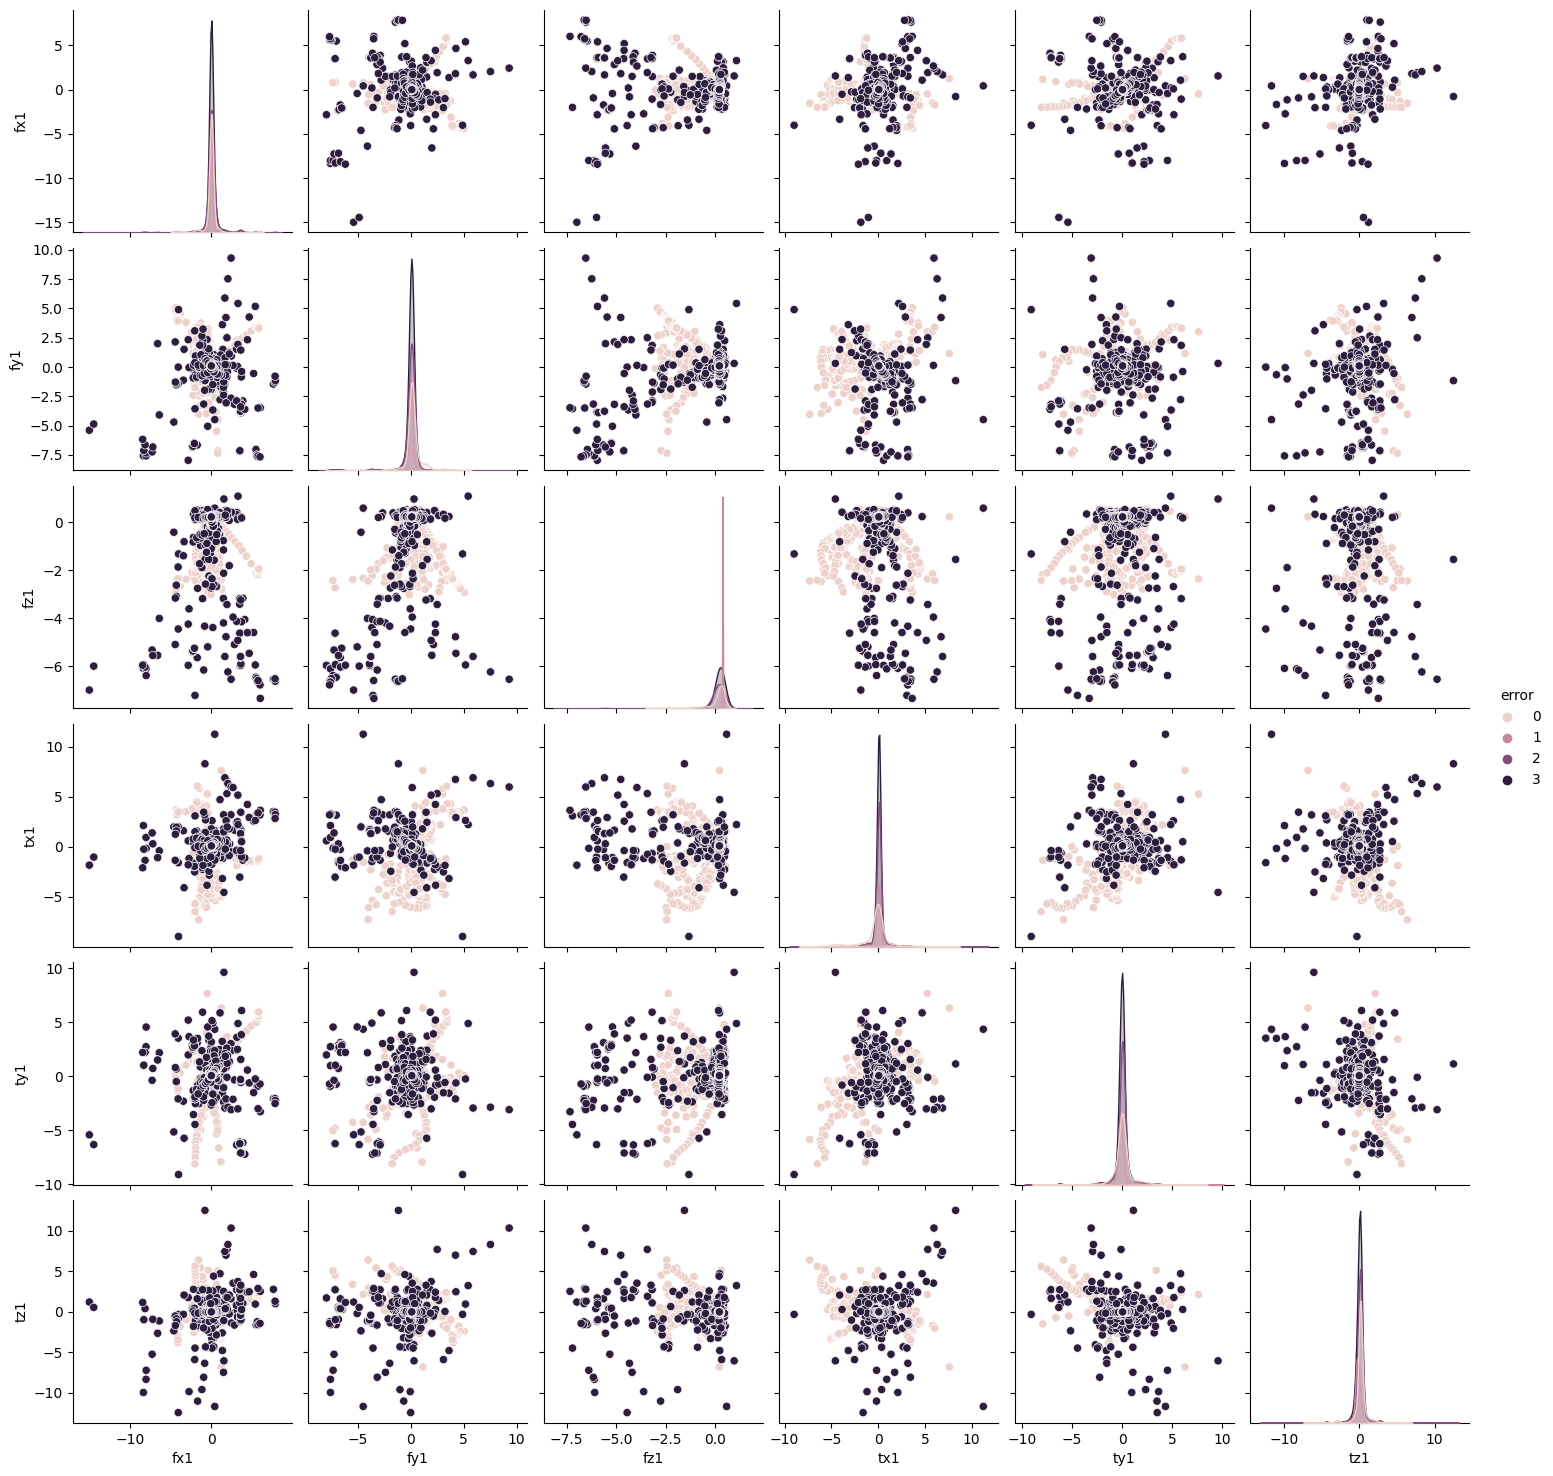

In [ ]:
sns.pairplot(robot_data[['fx1', 'fy1', 'fz1', 'tx1', 'ty1', 'tz1', 'error']], hue = 'error', diag_kind='kde')


# Neural Network Approach
---

In [ ]:

model = ks.Sequential([
    ks.layers.Dense(128, activation='relu', input_shape = (NUM_FEATURES,), kernel_regularizer=l2(0.001)),
    ks.layers.Dropout(0.3),
    ks.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    ks.layers.Dropout(0.3),
    ks.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    ks.layers.Dropout(0.3),
    ks.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.compile(optimizer = Adam(lr=ALPHA), loss = 'categorical_crossentropy', metrics = ['accuracy'])

training_target = to_categorical(training_target, num_classes=NUM_CLASSES)
test_target = to_categorical(test_target, num_classes=NUM_CLASSES)


# epochs = 250 for testing purposes, verbose = 0 to make it shut up lol
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

history = model.fit(training_features, training_target, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 0,
                    validation_split=0.2, callbacks=[early_stopping, lr_reduction])


Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


# Plotting MSE and Loss

In [ ]:
print(model.evaluate(test_features, test_target, batch_size = BATCH_SIZE))


39/39 [==============================] - 0s 2ms/step - loss: 0.7382 - accuracy: 0.5849
[0.7381716966629028, 0.5849359035491943]


# Decision Forests Approach
---

In [ ]:
forest_model = tfdf.keras.GradientBoostedTreesModel(
    num_trees = 10,
    growing_strategy = "BEST_FIRST_GLOBAL",
    max_depth = 3,
    min_examples = 20,
    split_axis = "SPARSE_OBLIQUE",
    validation_ratio=0.0
    )
forest_model.compile(metrics = 'accuracy')
training_ds = tfdf.keras.pd_dataframe_to_tf_dataset(training_ds_raw, label = 'error')
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_raw, label = 'error')

forest_model.fit(x = training_ds, validation_data = valid_ds, verbose=1)
tfdf.model_plotter.plot_model_in_colab(forest_model, tree_idx=0)

Use /tmp/tmpl60d0nxp as temporary training directory
Reading training dataset...
[WARNING 23-05-23 16:53:30.9357 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-05-23 16:53:30.9357 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-05-23 16:53:30.9357 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-05-23 16:53:31.005020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [4992]
	 [[{{node Placeholder/_6}}]]
Training dataset read in 0:00:05.058644. Found 4992 examples.
Reading validation dataset...
2023-05-23 16:53:36.061900: I tensorflow/core/common_runtime/executor.cc:1197

In [ ]:
print(forest_model.summary())

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	fx1
	fy1
	fz1
	tx1
	ty1
	tz1

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "fz1"  0.541586 ################
    2. "fx1"  0.375335 ######
    3. "fy1"  0.320305 ###
    4. "tx1"  0.280187 #
    5. "ty1"  0.254468 
    6. "tz1"  0.254411 

Variable Importance: NUM_AS_ROOT:
    1. "fz1" 24.000000 ################
    2. "fx1"  9.000000 ####
    3. "fy1"  4.000000 
    4. "tx1"  3.000000 

Variable Importance: NUM_NODES:
    1. "fz1" 112.000000 ################
    2. "fx1" 76.000000 ##########
    3. "fy1" 62.000000 ########
    4. "tx1" 15.000000 ##
    5. "tz1"  2.000000 
    6. "ty1"  1.000

# K-Nearest Neighbors Model

In [ ]:
# Why this is required is beyond me
tf.compat.v1.disable_eager_execution()

k = 100

updated_test_x = tf.compat.v1.placeholder(shape = [None, NUM_FEATURES], dtype = tf.float32)
updated_training_x = tf.compat.v1.placeholder(shape = [None, NUM_FEATURES], dtype = tf.float32)
updated_training_y = tf.compat.v1.placeholder(shape = [None, NUM_CLASSES], dtype = tf.float32)


tf.reduce_sum(tf.abs(tf.subtract(updated_training_x, tf.expand_dims(updated_test_x, 1))), axis = 2)
manhattan_dist = tf.reduce_sum(tf.abs(tf.subtract(updated_training_x, tf.expand_dims(updated_test_x, 1))), axis = 2)

inverse_distances = 1 / manhattan_dist

# Find the nearest k points
_, top_k_indices = tf.nn.top_k(tf.negative(manhattan_dist), k = k)
top_k_labels = tf.gather(updated_training_y, top_k_indices)

summed_pred = tf.reduce_sum(top_k_labels, axis = 1)
make_prediction = tf.argmax(summed_pred, axis = 1)

sess = tf.compat.v1.Session()

outcome_prediction = sess.run(make_prediction, feed_dict = {
    updated_training_x: training_features,
    updated_test_x: test_features,
    updated_training_y: training_target}
)

accuracy = 0
out_len = len(outcome_prediction)
for pred, actual in zip(outcome_prediction, test_target):
    if pred == np.argmax(actual):
        accuracy += 1 / out_len

print(f"Valid accuracy: {accuracy}")

2023-05-23 16:53:40.161366: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
Valid accuracy: 0.5056089743589728


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b63f49d-657e-40c3-abbf-efbd6029b8d0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>